<a target="_blank" href="https://colab.research.google.com/github/evaalonsoortiz/ELE8812-demos/blob/main/Demos/Lesson%207/Le%C3%A7on_7_Demo_lap.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# ELE8812 - Segmentation

## Démo : Détection de contours par laplacien (méthode Marr-Hildreth)

### Référence: DIP 4e édition, Chapitre 10, « The Marr-Hildreth Edge Detector » p.724

Dans ce démo, la méthode Marr-Hildreth sera utilisée pour détecter les contours d’une image de cerveau. L’objectif est d’obtenir les contours principaux qui délimitent, par exemple, la matière blanche, la matière grise, les ventricules et le crâne. La méthode Marr-Hildreth consiste à convoluer l’image avec le laplacien d’une gaussienne 2D (fonction LoG). Cette fonction peut être approximée avec un filtre spatial de taille n x n. Parce que la convolution et le laplacien sont des opérations linéaires, ceci est équivalent à appliquer un filtre passe-bas gaussien avant de calculer le laplacien de l’image. Dans ce démo, la fonction `scipy.ndimage.gaussian_laplace` est utilisé pour effectuer ces 2 étapes. Puisque le laplacien calcule les différences secondes, les contours correspondent aux passages par zéro en direction horizontale ou verticale. Comme dans le démo Leçon_7_Demo_grad, un seuil peut être appliqué pour rendre la détection de contours plus sélective. Seuls les passages à zéro impliquant une différence plus élevée que le seuil entre les 2 pixels de signes différents seront détectés comme étant des contours.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.ndimage import gaussian_filter, laplace, gaussian_laplace
import math
import cv2

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Option d'affichage
plt.rcParams['figure.figsize'] = (25,10)
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.titlepad'] = 15
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [ ]:
!git clone https://github.com/evaalonsoortiz/ELE8812-demos.git Repo

Mounted at /content/drive


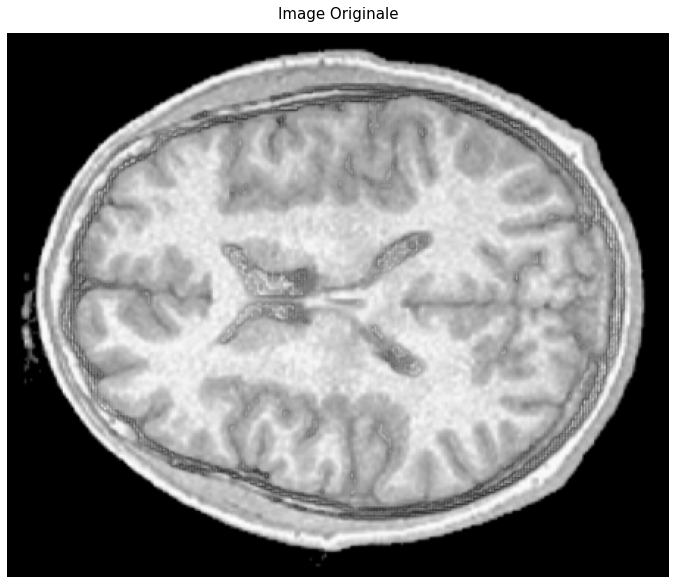

In [ ]:
# Charger image
A = plt.imread('Repo/Data/cerveau.tif').astype(float);
plt.imshow(A, cmap='gray'); plt.title('Image Originale'); plt.axis('off'); plt.show();

## Détection de contours

Pour la visualisation, le résultat de la détection est superposé à l’image originale. D’abord, sans effectuer de seuillage et avec un filtre gaussien ayant un écart-type de 2 (`sigma`), on observe beaucoup de fausses détections.

In [ ]:
def marr_hildreth(img, sigma=1, thr=0.1):
    """Détection de contours avec la méthode Marr-Hildreth
    
    img (ndarray): Image d'entrée.
    sigma (float): Écart-type de la gaussienne.
    thr (float): Seuil de détection de contours (valeur attendue entre 0 et 1).
    """
    # Application de LoG
    log = gaussian_laplace(img, sigma=sigma)
    
    edges_log = np.zeros(log.shape)
    edges_thr = np.zeros(log.shape)
    
    # Trouver les passage par zero
    edges_log[np.where(np.diff(np.sign(log), axis=0))] = 1
    edges_log[np.where(np.diff(np.sign(log), axis=1))] = 1
    
    # Trouver les différences de gradient les plus importantes
    norm_thr = np.diff(log).max() * thr
    edges_thr[np.where(np.diff(log, axis=0) > norm_thr)] = 1
    edges_thr[np.where(np.diff(log, axis=1) > norm_thr)] = 1
    
    return edges_log * edges_thr

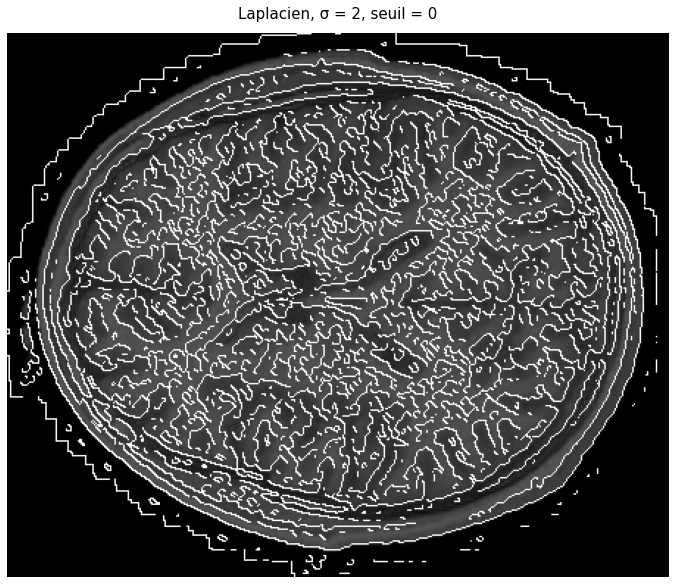

In [ ]:
# Find edges using Laplacian of Gaussian "LoG"
# contours = binary image with 1s where there is an edge and 0s elsewhere
# sigma = standard deviation of Gaussian
# seuil = treshold
seuil = 0
sigma = 2

contours = marr_hildreth(A, sigma=2, thr=seuil)

fac = 3
iml = np.minimum(np.double(A)/(256*fac-1) + contours, 1)

plt.imshow(iml, cmap='gray'); plt.title('Laplacien, \u03C3 = '+str(sigma)+', seuil = 0'); plt.axis('off'); plt.show();

## Effet de sigma

L’augmentation de l’écart-type du filtre gaussien à 4, lisse d’avantage l’image et rend la détection de contours plus robuste au bruit. Moins de fausses détections sont obtenues. Or, comme à l’exemple précédent, on observe un contour détecté en périphérie du crâne qui ne semble pas correspondre à un vrai contour de l’image. L’augmentation de l’écart-type du filtre gaussien déplace ce contour encore plus vers les bords de l’image. Ceci est un artéfact causé par le lissage de l’image. Après l’application du filtre gaussien passe-bas, certains pixels de fond proche du contour du crâne ont une valeur plus élevée que sur l’image originale et de faux contours sont créés.

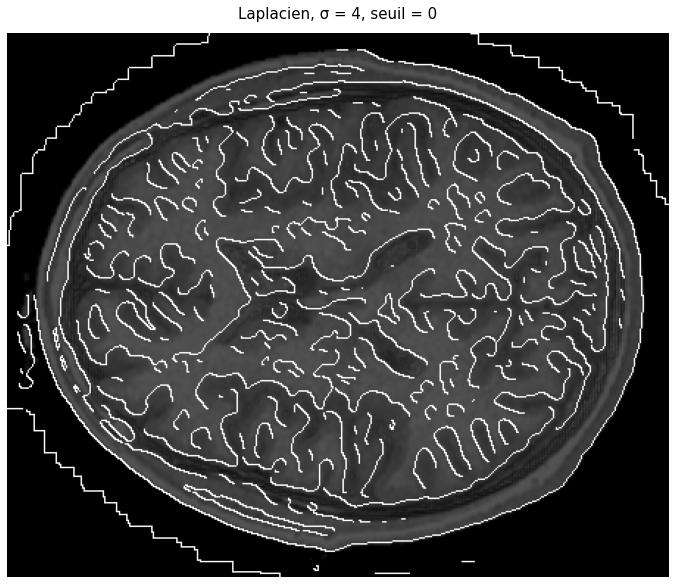

In [ ]:
# greater smoothing of the original image leads to less detailed edges

seuil = 0
sigma = 4

contours = marr_hildreth(A, sigma=sigma, thr=seuil)

fac = 3
iml = np.minimum(np.double(A)/(256*fac-1) + contours, 1)

plt.imshow(iml, cmap='gray'); plt.title('Laplacien, \u03C3 = '+str(sigma)+', seuil = 0'); plt.axis('off'); plt.show();

## Effet du seuil

Un seuillage peut être effectué pour réduire les fausses détections obtenues aux exemples précédents. Avec un seuil de 0.1, beaucoup moins de fausses détections sont obtenues mais certaines parties des vrais contours ne sont pas détectées (comme dans le démo Leçon_7_Demo_grad). À noter : cette méthode donne des contours plus minces que ceux obtenus avec le gradient (filtres Sobel).

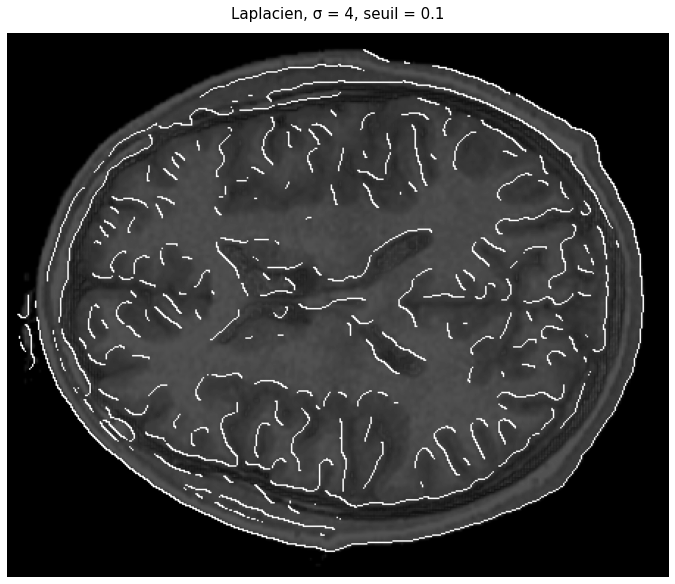

In [ ]:
seuil = 0.1
sigma = 4

contours = marr_hildreth(A, sigma=sigma, thr=seuil)

fac = 3
iml = np.minimum(np.double(A)/(256*fac-1) + contours, 1)

plt.imshow(iml, cmap='gray'); plt.title('Laplacien, \u03C3 = '+str(sigma)+', seuil = 0.1'); plt.axis('off'); plt.show();